# Nerdle Solver - Initial Guess Assessment Optimization
We prove (by brute-force) that you can always solve mini-Nerdle in at most $4$ guesses regardless of the starting expression, provided you use the optimal strategy. The worst start having repeating numbers and thus less information, e.g. `10-5=5`. The best start has all different numbers: `28/7=4`, which needs at most $3$ guesses and $2.65 \pm 0.5$ guesses.

To find the best initial guess, we map out the game tree.

In [2]:
%load_ext autoreload
%autoreload 2

import collections
import ctypes
import itertools
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats
import cProfile
import pstats
import os
from pstats import SortKey

import analysis
import nerdle
import score as s
import generator
sgo = ctypes.CDLL(s.SCORE_GUESS_OPT_SO)
from nerdle import Hint

## Initial Guess Optimization

In [3]:
slot_values = np.arange(5, 9, dtype=int)

In [64]:
tree_by_slots = {}
for num_slots in slot_values:
    print("num_slots", num_slots)
    db_file = "db/nerdle{}.db".format(num_slots) 
    solver_data = nerdle.create_solver_data(num_slots, db_file)
    d = solver_data.score_db

    tree_file = "db/nerdle{}_tree.pkl".format(num_slots) 
    if os.path.exists(tree_file):
        print("Loading tree")
        with open(tree_file, 'rb') as f:
            tree = pickle.load(f)
    else:
        print("Building tree")
        %time tree = analysis.GameTreeBuilder(solver_data).build()
        with open(tree_file, 'wb') as f:
            pickle.dump(tree, f)
    tree_by_slots[num_slots] = tree

num_slots 5
Building tree
num_slots 6
Building tree
num_slots 7
Building tree
num_slots 8
Building tree


In [79]:
# Multilevel max bucket estimation.
tree_by_slots_ml = {}
for num_slots in slot_values:
    print("num_slots", num_slots)
    db_file = "db/nerdle{}.db".format(num_slots) 
    solver_data = nerdle.create_solver_data(num_slots, db_file)
    d = solver_data.score_db

    print("Building tree")
    tree_file = "db/nerdle{}_tree_ml.pkl".format(num_slots) 
    if os.path.exists(tree_file):
        with open(tree_file, 'rb') as f:
            tree = pickle.load(f)
    else:
        %time tree = analysis.GameTreeBuilder(solver_data).build(strategy="multilevel")
        with open(tree_file, 'wb') as f:
            pickle.dump(tree, f)
    tree_by_slots_ml[num_slots] = tree

num_slots 5
Building tree
CPU times: user 130 ms, sys: 2.05 ms, total: 132 ms
Wall time: 135 ms
num_slots 6
Building tree
CPU times: user 128 ms, sys: 2.79 ms, total: 131 ms
Wall time: 134 ms
num_slots 7
Building tree
Unexpected exception formatting exception. Falling back to standard exception
num_slots 8


Traceback (most recent call last):
  File "/Users/olivne/opt/miniconda3/envs/nerdle/lib/python3.10/site-packages/IPython/core/magics/execution.py", line 1316, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "/Users/olivne/oren/nerdle-solver/analysis.py", line 56, in build
    pre_traversal(root, lambda node: self._process_node(node, quantity), debug=debug)
  File "/Users/olivne/oren/nerdle-solver/analysis.py", line 153, in pre_traversal
  File "/Users/olivne/oren/nerdle-solver/analysis.py", line 153, in pre_traversal
  File "/Users/olivne/oren/nerdle-solver/analysis.py", line 149, in pre_traversal
    print("\t" * depth, node)
  File "/Users/olivne/oren/nerdle-solver/analysis.py", line 56, in <lambda>
    pre_traversal(root, lambda node: self._process_node(node, quantity), debug=debug)
  File "/Users/olivne/oren/nerdle-solver/analysis.py", line 68, in _process_node
    bucket_sizes = bucket_size_functor(score)
  File "/Users/olivne/oren/nerdle-s

Building tree


KeyboardInterrupt: 

In [67]:
freq_by_slots = {}
min_num_guesses, max_num_guesses = 2, 5
for num_slots in slot_values:
    tree = tree_by_slots[num_slots]
    tdc = analysis.TreeDepthCalculator(tree)
    # Distribution of #guesses for all answers.
    num_guesses = np.array([depth for node, depth in tdc.depth.items() if not node.children]) + 1
    freq = collections.Counter(num_guesses)
    num_leaves = sum(1 for node in tdc.depth if not node.children)

    print("#slots {} Avg {:.2f} +- {:.2f} Best initial guess {} #nodes {} #leaves {}".format(
        num_slots, np.mean(num_guesses), np.std(num_guesses), tree.key[1], len(tdc.depth), num_leaves))
    freq_by_slots[num_slots] = [100 * freq[k] / num_leaves if k in freq else 0 for k in range(min_num_guesses, max_num_guesses+1)]
    for k, v in zip(range(min_num_guesses, max_num_guesses+1), freq_by_slots[num_slots]):
        print("{} guesses: {:6.2f}%".format(k, v))

#slots 5 Avg 3.62 +- 0.93 Best initial guess 1+2=3 #nodes 286 #leaves 217
2 guesses:   8.76%
3 guesses:  43.78%
4 guesses:  24.42%
5 guesses:  23.04%
#slots 6 Avg 2.86 +- 0.37 Best initial guess 3*8=24 #nodes 250 #leaves 206
2 guesses:  15.05%
3 guesses:  83.98%
4 guesses:   0.97%
5 guesses:   0.00%
#slots 7 Avg 3.40 +- 0.52 Best initial guess 24-16=8 #nodes 9363 #leaves 7561
2 guesses:   1.44%
3 guesses:  57.23%
4 guesses:  41.33%
5 guesses:   0.00%
#slots 8 Avg 3.29 +- 0.49 Best initial guess 58-46=12 #nodes 21593 #leaves 17723
2 guesses:   1.68%
3 guesses:  67.70%
4 guesses:  30.62%
5 guesses:   0.00%


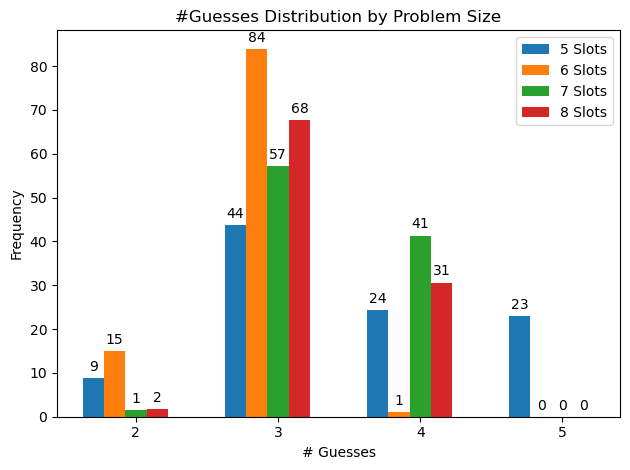

In [604]:
labels = list(map(str, range(min_num_guesses, max_num_guesses+1)))

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects = [None] * num_slots
for i, num_slots in enumerate(slot_values):
    rects[i] = ax.bar(x + (i - 0.5 * len(slot_values)) * width, freq_by_slots[num_slots], width, label='{} Slots'.format(num_slots))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('# Guesses')
ax.set_ylabel('Frequency')
ax.set_title('#Guesses Distribution by Problem Size')
ax.set_xticks(x, labels)
ax.legend()
for i in range(len(slot_values)):
    ax.bar_label(rects[i], labels=["{:.0f}".format(x) for x in freq_by_slots[slot_values[i]]], padding=3)
#for rect in rects:
#    ax.bar_label(rect, padding=3)
fig.tight_layout()
plt.show()

In [377]:
for num_slots in slot_values:
    print("num_slots", num_slots)
    db_file = "db/nerdle{}.db".format(num_slots) 
    solver_data = nerdle.create_solver_data(num_slots, db_file)
    d = solver_data.score_db
    answers = solver_data.all_keys
    %time bucket_size, _, k = min((max(collections.Counter(d[k]).values()), k not in answers, k) for k in solver_data.all_keys)
    b = collections.Counter(d[k]).values()
    print("{} bucket size {} reduction factor {:.1f} # buckets {}".format(
        solver_data.answers[k], bucket_size, d.shape[1] / bucket_size, len(b)))

num_slots 5
CPU times: user 10.6 ms, sys: 125 µs, total: 10.7 ms
Wall time: 10.9 ms
1+2=3 bucket size 42 reduction factor 5.2 # buckets 43
num_slots 6
CPU times: user 9.94 ms, sys: 106 µs, total: 10 ms
Wall time: 10.2 ms
3*8=24 bucket size 10 reduction factor 20.6 # buckets 73
num_slots 7
CPU times: user 7.29 s, sys: 14.6 ms, total: 7.31 s
Wall time: 7.32 s
24-16=8 bucket size 158 reduction factor 47.9 # buckets 543
num_slots 8
CPU times: user 40.6 s, sys: 85.1 ms, total: 40.7 s
Wall time: 40.8 s
58-46=12 bucket size 101 reduction factor 175.5 # buckets 1650


* It seems like odd-size Nerdle is harder than even-size! Larger average #guesses.
* Diversifying symbols of initial guess is a generally good criterion.

In [124]:
num_slots = 8
print("num_slots", num_slots)
db_file = "db/nerdle{}.db".format(num_slots) 
solver_data = nerdle.create_solver_data(num_slots, db_file)
d = solver_data.score_db

num_slots 8


In [123]:
# cProfile.run('tree = analysis.GameTreeBuilder(solver_data, max_answers=2000).build()', 'stats')
# p = pstats.Stats('stats')
# p.sort_stats(SortKey.CUMULATIVE).print_stats(10)

In [125]:
cProfile.run('tree = analysis.GameTreeBuilder(solver_data).build(strategy="multilevel", sample_factor=1.5)', 'stats')
p = pstats.Stats('stats')
p.sort_stats(SortKey.CUMULATIVE).print_stats(20)

(17723, 17723) min_biased_multilevel_sampling


KeyboardInterrupt: 

In [9]:
# scipy.stats.mode has a larger overhead than Counter.most_common(), but is faster for large arrays.
for rows in (1000, 10000):
    for cols in (5, 250, 500):
        a = np.random.randint(10, size=(rows, cols))
        r1 = %timeit -r 1 -o -q min(collections.Counter(row).most_common(1)[0][1] for row in a);
        r2 = %timeit -r 1 -o -q min(scipy.stats.mode(a, axis=1, keepdims=False)[1]);
        print(rows, cols, r1.all_runs[0], r2.all_runs[0])

1000 5 0.3496340000128839 0.20788274297956377
1000 250 0.294898482010467 0.2633685609907843
1000 500 0.5520167700015008 0.3147114369785413
10000 5 0.36427297300542705 0.20441173799918033
10000 250 0.2902718990226276 0.26729287300258875
10000 500 0.5486853229813278 0.3630345569981728


In [131]:
# Multilevel starts spaying off around n = 2000 columns.
quantity = lambda a: analysis.max_bucket_sizes(a) / a.shape[1]

for n in ( d.shape[1], ): # 2000, 4000, 6400, 12800,
    print(n)
    a = d[:, :n]

    r = %timeit -o -r 1 -q b = analysis.max_bucket_sizes(a) / a.shape[1]
    print(min(b), np.argmin(b), "time", r.timings[0])

    r = %timeit -o -r 1 -q approx = analysis.min_biased_multilevel_sampling(a, quantity, sample_factor=1.5, debug=True)
    print(min(approx), np.argmin(approx), r.timings[0])

17723
0.020285714285714285 1563 time 11.021933993004495
#rows 17723 x sample_size 2000 = 35446000
#rows 8861 x sample_size 3000 = 26583000
#rows 4430 x sample_size 4500 = 19935000
#rows 2215 x sample_size 6750 = 14951250
#rows 1107 x sample_size 10125 = 11208375
#rows 553 x sample_size 15187 = 8398411
#rows 276 x sample_size 17723 = 4891548
#rows 17723 x sample_size 2000 = 35446000
#rows 8861 x sample_size 3000 = 26583000
#rows 4430 x sample_size 4500 = 19935000
#rows 2215 x sample_size 6750 = 14951250
#rows 1107 x sample_size 10125 = 11208375
#rows 553 x sample_size 15187 = 8398411
#rows 276 x sample_size 17723 = 4891548
0.020285714285714285 1563 13.709664375986904


In [129]:
a = d[:, :6000]
cProfile.run('analysis.min_biased_multilevel_sampling(a, quantity, sample_factor=1.5, debug=True)', 'stats')
p = pstats.Stats('stats')
p.sort_stats(SortKey.CUMULATIVE).print_stats(30)

#rows 17723 x sample_size 2000 = 35446000
#rows 8861 x sample_size 3000 = 26583000
#rows 4430 x sample_size 4500 = 19935000
#rows 2215 x sample_size 6000 = 13290000
Wed Sep 21 10:33:37 2022    stats

         1230483 function calls (1130779 primitive calls) in 9.473 seconds

   Ordered by: cumulative time
   List reduced from 131 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    9.473    9.473 {built-in method builtins.exec}
        1    0.000    0.000    9.472    9.472 <string>:1(<module>)
        1    2.956    2.956    9.472    9.472 /Users/olivne/oren/nerdle-solver/analysis.py:95(min_biased_multilevel_sampling)
        4    0.000    0.000    6.514    1.628 /var/folders/3k/z6rf4cwj2b1bs57qshd9j_k4fbwv1r/T/ipykernel_94409/384655824.py:2(<lambda>)
        4    0.000    0.000    6.514    1.628 /Users/olivne/oren/nerdle-solver/analysis.py:88(max_bucket_sizes)
        4    0.079    0.020    6.513    1.628 

0.07419653484988759 7561 3786 969


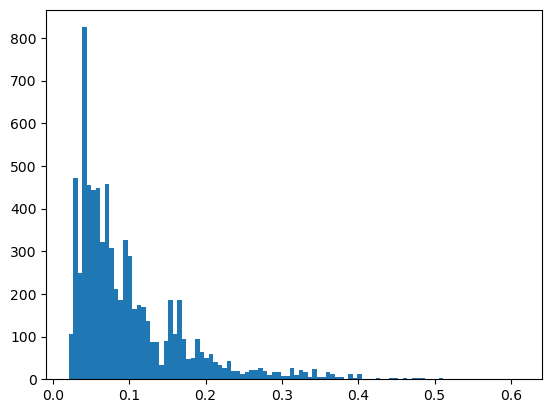

In [51]:
b_median = np.median(b)
print(b_median, len(b), len(np.where(b <= b_median)[0]), len(np.unique(b)))
plt.hist(b, bins=100);

In [97]:
# num_slots = 7
# print("num_slots", num_slots)
# db_file = "db/nerdle{}.db".format(num_slots) 
# solver_data = nerdle.create_solver_data(num_slots, db_file)
# d = solver_data.score_db

# %time tree = analysis.GameTreeBuilder(solver_data).build(strategy="multilevel")